# Setup

In [1]:
import pickle
import tensorflow as tf

from util import *
from biomedical_qa.inference.inference import Inferrer, get_model_and_session
from biomedical_qa.sampling.bioasq import BioAsqSampler

import matplotlib.pyplot as plt
%pylab inline
pylab.rcParams['figure.figsize'] = (10, 6)

Populating the interactive namespace from numpy and matplotlib


In [2]:
CONFIG = "../model_checkpoints/simple_pointer_with_chars/bioasq_finetune_dr05_sigmoid_bioasqtrainer_ckptits200/config.pickle"

model, sess = get_model_and_session(CONFIG, ["cpu:0"])
inferrer = Inferrer(model, sess, beam_size=1)

Loading Model...
Using weights: ../model_checkpoints/simple_pointer_with_chars/bioasq_finetune_dr05_sigmoid_bioasqtrainer_ckptits200/final_model.tf
Restoring Weights...


In [3]:
vocab = inferrer.model.embedder.vocab
rev_vocab = [""] * len(vocab)
for w, i in vocab.items():
    rev_vocab[i] = w

In [4]:
sampler = BioAsqSampler("../data/BioASQ", ["dev.json"], 16, vocab=vocab, shuffle=False)

# Run Model

In [5]:
predictions = inferrer.get_predictions(sampler)

# Factoid Analysis

In [6]:
factoid_predictions = {id: p for id, p in predictions.items() if p.question.q_type == "factoid"}

In [7]:
for prediction in factoid_predictions.values():
    
    print_prediction(prediction, rev_vocab)

Id:
  5509bd6a1180f13250000002
Question:
  what disease is small bowel lymphoma commonly associated with
Answers:
 * Celiac disease
 * gluten-associated enteropathy
 * CELIAC SPRU
 * Non tropical spru
 * Gluten Sensitive Enteropath
Predicted Answers:
 * ('celiac disease', 0.99931264)

Id:
  54fc91e96ad7dcbc12000001
Question:
  pbt2 has been tested for which disorder?
Answers:
 * Alzheimer's disease
Predicted Answers:
 * ("Alzheimer's dementia", 0.74536544)

Id:
  52bf1f2d03868f1b06000015
Question:
  which drug is benserazide usually co-administered with?
Answers:
 * L-Dopa
Predicted Answers:
 * ('levodopa', 0.97044557)

Id:
  517170c48ed59a060a00000d
Question:
  how many selenoproteins are encoded in the human genome?
Answers:
 * 25
Predicted Answers:
 * ('25', 0.99572796)

Id:
  51542e44d24251bc05000081
Question:
  mutations in which gene determine response to both erlotinib and gefitinib?
Answers:
 * epidermal growth factor receptor (EGFR) gene
Predicted Answers:
 * ('EGFR', 0.998544

In [8]:
def is_correct_lenient(prediction):
    correct_answers = maybe_flatten_list(prediction.question.question_json["original_answers"])
    for correct_answer in correct_answers:
        for predicted_answer in prediction.answer_strings:
            if correct_answer.lower().strip() == predicted_answer.lower().strip():
                return True
    return False

In [9]:
correct_predictions = {id: p for id, p in factoid_predictions.items() if is_correct_lenient(p)}
incorrect_predictions = {id: p for id, p in factoid_predictions.items() if not is_correct_lenient(p)}

print("Correct: %d, Incorrect: %d" % (len(correct_predictions), len(incorrect_predictions)))

Correct: 15, Incorrect: 28


## Pointer Visualization (Incorrect Answer)

In [10]:
for prediction in incorrect_predictions.values():
    print_prediction(prediction, rev_vocab)

Id:
  530c7f52970c65fa6b000010
Question:
  oxantel is used for periodontitis treatment. how does it work?
Answers:
 * Oxantel disrupts polymicrobial biofilm
Predicted Answers:
 * ('inhibit fumarate reductase', 0.99005467)

Id:
  54fc91e96ad7dcbc12000001
Question:
  pbt2 has been tested for which disorder?
Answers:
 * Alzheimer's disease
Predicted Answers:
 * ("Alzheimer's dementia", 0.74536544)

Id:
  52bf1f2d03868f1b06000015
Question:
  which drug is benserazide usually co-administered with?
Answers:
 * L-Dopa
Predicted Answers:
 * ('levodopa', 0.97044557)

Id:
  51542e44d24251bc05000081
Question:
  mutations in which gene determine response to both erlotinib and gefitinib?
Answers:
 * epidermal growth factor receptor (EGFR) gene
Predicted Answers:
 * ('EGFR', 0.99854434)

Id:
  54ff45966ad7dcbc12000010
Question:
  which protein is causing netherton syndrome?
Answers:
 * LEKTI
 * lymphoepithelial Kazal type-related inhibitor
Predicted Answers:
 * ('Kazal-type inhibitor LEKTI-1 \nNethe

In [11]:
prediction = incorrect_predictions["54fc99f36ad7dcbc12000004"]

In [12]:
print_prediction(prediction, rev_vocab)

Id:
  54fc99f36ad7dcbc12000004
Question:
  neurostimulation of which nucleus is used for treatment of dystonia?
Answers:
 * globus pallidus internus
Predicted Answers:
 * ('globus pallidus internus (GPi)', 0.77401483)



In [14]:
tokens = get_tokens(prediction, rev_vocab)

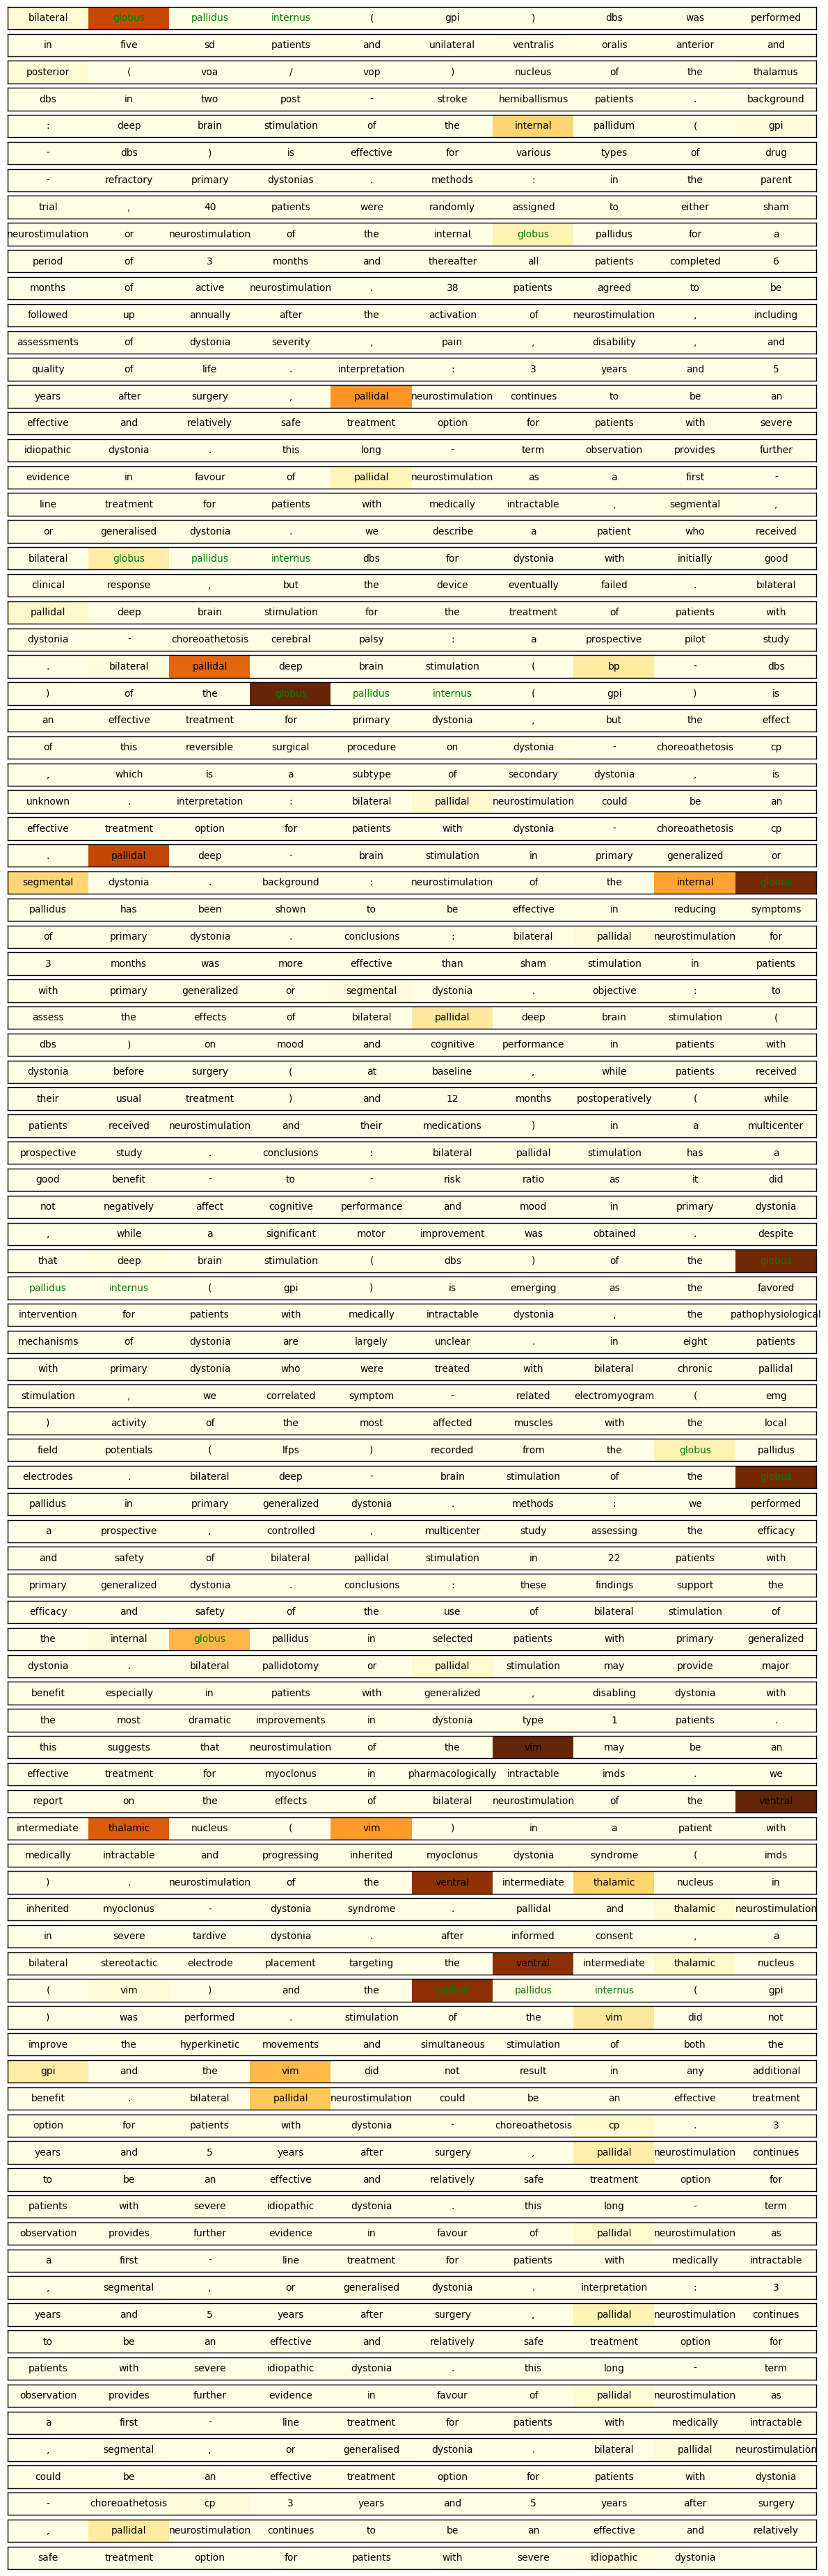

In [15]:
correct_tokens = find_correct_tokens(prediction.question)

text_heatmap(tokens, prediction.prediction.start_probs, correct_tokens)

In [ ]:
# TODO
#start_token_mask = np.zeros(len(tokens), dtype=np.bool)
#start_token_mask[prediction.starts[0]] = True

#text_heatmap(tokens, prediction.end_scores[0], start_token_mask)